In [1]:
using Plots
using StatsPlots
using JLD2
using MPSTime
using StatsBase
using Measures
using LaTeXStrings
# using Makie
# using CairoMakie

In [9]:
function map_to_pm(windows, pms)
    l = maximum(vcat(windows...))
    inds = [ argmin(abs.(pms .- length(w)/l*100)) for w in windows]
    return pms[inds]
end

function sort_by_pms(results, windows, pms)
    percs = map_to_pm(windows, pms)
    res_by_pm = []
    for pm in pms
        push!(res_by_pm, results[percs .== pm])
    end
    return res_by_pm
end

function sort_by_pms(fold, pms)

    return sort_by_pms(fold["loss"], fold["eval_windows"], pms)
end

function loss_by_pm(res, pms; scale::Float64 = 1.)
    losses = map(f -> sort_by_pms(f, pms) ./ scale, res) 
    # return mapreduce(f -> sort_by_pms(f, pms), +, res) / length(res)
    pm_mean = [mean.(l) for l in losses]
    return mean(losses), std(hcat(pm_mean...); dims=2)

end

function mmae_std_by_pm(res, pms; scale::Float64 = 1.)
    mean_by_pm, std_by_pm = loss_by_pm(res, pms; scale=scale)

    return mean.(mean_by_pm), std_by_pm
end

mmae_std_by_pm (generic function with 1 method)

In [10]:
function hm_convert(xs,ys,zs, annotations=false; verbosity=0)
    xs_full = range(extrema(xs)...)
    ys_full = range(extrema(ys)...)

    zs_full = Matrix{Union{Float64,Missing}}(missing, length(ys_full), length(xs_full))

    scale = ones(Int, size(zs_full)...)
    dupes = 0
    n = length(zs)
    anns = Dict{Tuple, Any}()
    for (i, z) in enumerate(zs)
        xi = findfirst(==(xs[i]), xs_full)
        yi = findfirst(==(ys[i]), ys_full)

        if ismissing(zs_full[yi, xi])
            zs_full[yi, xi] = z

        else
            zs_full[yi, xi] += z
            scale[yi, xi] += 1
            dupes += 1
        end
        anns[xs[i], ys[i]] =  text("$(scale[yi,xi])", halign=:center, valign=:center, color=:white)

    end
    verbosity >= 1 && println("n=$n, Duplicates=$dupes")

    if annotations
        xs_ann, ys_ann, ts_ann = [],[],[]
        for ((x,y), text) in pairs(anns)
            push!(xs_ann, x)
            push!(ys_ann, y)
            push!(ts_ann, text)
        end
        return xs_full, ys_full, (zs_full ./= scale), (xs_ann, ys_ann, ts_ann)

    else

        return xs_full, ys_full, (zs_full ./= scale)
    end
end

function loss_opts(res; verbosity=0)
    losses = getindex.(res,"loss") .|> mean
    opts = getindex.(res, "opts")

    ds = getproperty.(opts, :d)
    chis = getproperty.(opts, :chi_max)
    etas = getproperty.(opts, :eta)
    nsw = getproperty.(opts, :nsweeps)
    return losses, ds, chis, nsw, etas
end

function get_hm_vals(res, annotations=true; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    return hm_convert(chis, ds, losses, annotations; verbosity=verbosity)
end

function map_dupes(res; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    pairs = zip(ds, chis, nsw) |> collect
    return countmap(pairs)
end

map_dupes (generic function with 1 method)

In [ ]:
pms = 5:10:95

@load "IPD/IPD_rand_250_ns.jld2" res
res_ECG = copy(res)


mmae_ECG, std_ECG = mmae_std_by_pm(res_IPD, pms)

([0.15502125514042406, 0.15757557937914263, 0.1699442716037779, 0.16538645956016482, 0.17311799237602532, 0.17794088407082712, 0.18880712495924512, 0.19647745530360747, 0.21110095465738396, 0.24962740193561894], [0.01027152715145583; 0.010365083773918562; … ; 0.010461231368960358; 0.015796101460624472;;])

In [14]:
f = jldopen("Josh/IPD/IPD_ImputationFinalResults_30Fold.jld2", "r");
res_IPD_paper = read(f, "mps_results")
res_IPD_nn = read(f, "nn_results")
close(f)

instances = length(res_IPD_paper[5][1])
mmae_IPD_paper = [mean([mean([mean(res_IPD_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_IPD_nn = [mean([mean([mean(res_IPD_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_IPD_paper = ([std([mean([mean(res_IPD_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_IPD_nn = ([std([mean([mean(res_IPD_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

10-element Vector{Float64}:
 0.008329537431858061
 0.008320325357159352
 0.008781910627708788
 0.008269664558263471
 0.008628720460549738
 0.009152587501041793
 0.009350555083258895
 0.009422439061856134
 0.009649422581143085
 0.01397327114562047

In [19]:
groupedbar(
    pms, 
    [ mmae_IPD  mmae_IPD_paper mmae_IPD_nn ]; 
    yerr =1.96 .* [std_IPD  std_IPD_paper std_IPD_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of IPD hyperparameter tuning\n VS data from paper")
savefig("ipd.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/ipd.png"

In [18]:
ds, chis, losses, anns = get_hm_vals(res_IPD)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each IPD Fold")
plot(hm)
savefig("IPD_heatmap.png")


"/home/noodles/.julia/dev/MPSTime.jl/Folds/IPD_heatmap.png"

# ECG

In [20]:
pms = 5:10:95

@load "ECG200/ECG_rand_250_ns.jld2" res
res_ECG = copy(res)


mmae_ECG, std_ECG = mmae_std_by_pm(res_ECG, pms)

([0.21620518598673102, 0.22314240674350364, 0.21939444892185084, 0.21923911333964646, 0.22743282316711289, 0.2433248437903279, 0.2531289808992191, 0.26057458068689104, 0.3020011981964288, 0.38238181179436614], [0.007402562399329372; 0.007768501299639522; … ; 0.013134015652216733; 0.01778310612347809;;])

In [23]:
f = jldopen("Josh/ECG/ECG200_ImputationFinalResults_30Fold.jld2", "r");
res_ECG_paper = read(f, "mps_results")
res_ECG_nn = read(f, "nn_results")
close(f)

instances = length(res_ECG_mps[5][1])
mmae_ECG_paper = [mean([mean([mean(res_ECG_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_ECG_nn = [mean([mean([mean(res_ECG_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_ECG_paper = ([std([mean([mean(res_ECG_paper[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_ECG_nn = ([std([mean([mean(res_ECG_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

10-element Vector{Float64}:
 0.008537606769123868
 0.008056621127721247
 0.00787910813251473
 0.008997652275113484
 0.008685880769342853
 0.009466021001200189
 0.010396690530985095
 0.010581085381700543
 0.012327006907051944
 0.014047063929430038

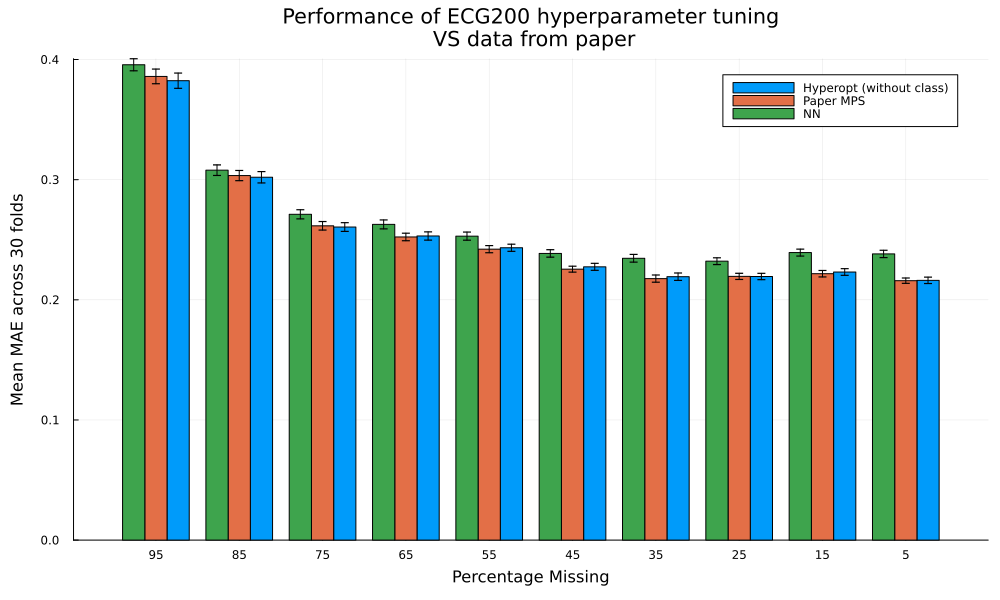

In [25]:
groupedbar(
    pms, 
    [ mmae_ECG  mmae_ECG_paper mmae_ECG_nn ]; 
    yerr =1.96 .* [std_ECG  std_ECG_paper std_ECG_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of ECG200 hyperparameter tuning\n VS data from paper")
# savefig("ECG200.png")

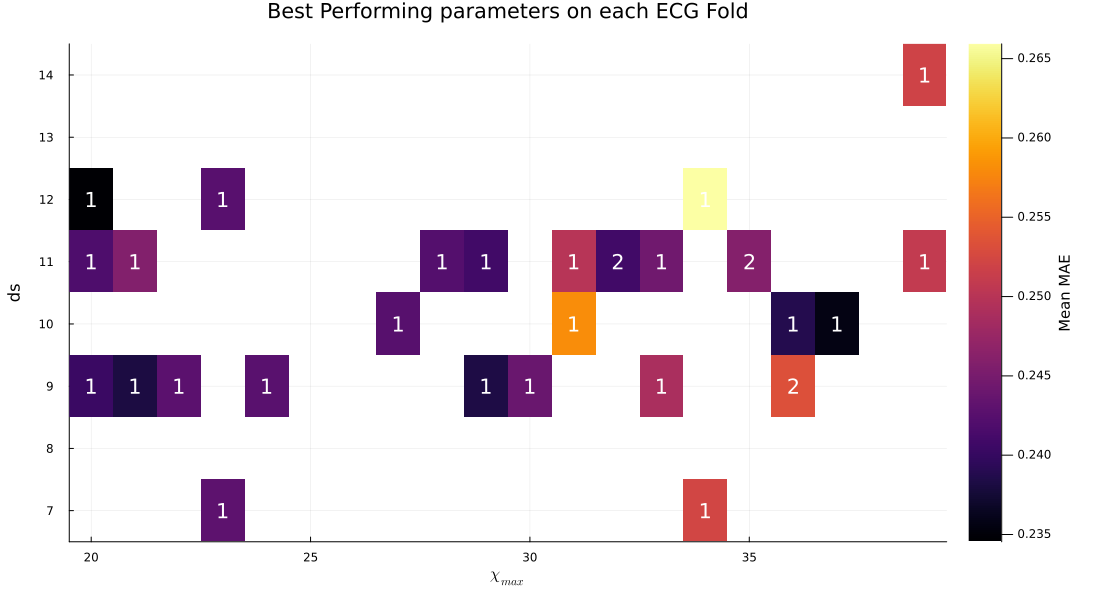

In [27]:
ds, chis, losses, anns = get_hm_vals(res_ECG)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG Fold")
plot(hm)
# savefig("ECG_heatmap.png")
